First we load `rpy2.ipython` extension so we can execute `R` code.

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Analyzing Experimental Data

# Getting started

## Load up the R packages we're going to use

In [28]:
%%R
suppressMessages({
    # install.packages(c('dplyr', 'tidyr', 'ggplot2', 'broom'))
    library(dplyr)
    library(tidyr)
    library(ggplot2)
    library(broom)
})

# Exposure logs
First we logged everytime a user loaded up the user interface. Often we want to only take the first exposure by a user.

In [29]:
%%R
src2ideology <- c(
    # <=liberal=====moderate====conservative=>
    'msnbc' = -1, 'cnn' = 0, 'foxnews' = 1)

Exp <- read.csv('data/exposure_mturk2_log.csv', stringsAsFactors = FALSE) %>%
    group_by(userid, story_key) %>%
    arrange(time) %>%
    summarise(source = first(source), position = first(position), time = first(time)) %>%
    mutate(source.ideology = src2ideology[source]) %>%
    ungroup

cat('We have', nrow(Exp), 'exposures.', '\n')
cat('We have', with(Exp, length(unique(userid))), 'potential subjects.', '\n\n')
head(Exp)

We have 492 exposures. 
We have 164 potential subjects. 

Source: local data frame [6 x 6]

  userid story_key  source position       time source.ideology
1   1388         2   msnbc        1 1431954455              -1
2   1388         7 foxnews        0 1431954455               1
3   1388         8     cnn        2 1431954455               0
4   2025         3 foxnews        0 1431955391               1
5   2025         5     cnn        2 1431955391               0
6   2025         8   msnbc        1 1431955391              -1


In [30]:
%%R
Exp %>% group_by(source.ideology) %>% summarise(n = n())

Source: local data frame [3 x 2]

  source.ideology   n
1              -1 164
2               0 164
3               1 164


# Events logs

The events log is produced by user actions that take place sometime after the exposure. So in this experiment we logged two kinds of these:  summaries and survey responses.

In [31]:
%%R
Sum <- read.csv('data/summary_mturk2_log.csv', stringsAsFactors = FALSE) %>%
    group_by(userid, story_key) %>%
    arrange(time) %>%
    summarise(summary = first(summary)) %>%
    ungroup

cat('We have', nrow(Sum), 'summaries.', '\n')
cat('We have', with(Sum, length(unique(userid))), 'subjects who wrote summaries.', '\n')
cat(with(Sum, round(mean(summary), 2)), 'stories were summarized.', '\n\n')
head(Sum)

We have 390 summaries. 
We have 130 subjects who wrote summaries. 
0.37 stories were summarized. 

Source: local data frame [6 x 3]

  userid story_key summary
1   1388         2       0
2   1388         7       0
3   1388         8       1
4   2025         3       0
5   2025         5       1
6   2025         8       0


#Survey responses

After the experiment, we survey the subjects about their political ideology.

In [32]:
%%R
Survey <- read.csv('data/survey_mturk2_log.csv', stringsAsFactors = FALSE) %>%
  filter(!is.na(response)) %>%
  group_by(userid) %>%
  arrange(time) %>%
  summarise(response = first(response), reversed_scale = first(reversed_scale)) %>%
  # Original scale is [0, 4] (from conservative to liberal)
  # let's convert it to [-2, 2] (liberal to conservative)
  mutate(subject.ideology = 2 - response) %>%
  ungroup

cat('We have ', nrow(Survey), 'survey responses.', '\n')
head(Survey)

We have  129 survey responses. 
Source: local data frame [6 x 4]

  userid response reversed_scale subject.ideology
1   1388        1              0                1
2   2025        2              0                0
3   2263        1              1                1
4   3856        2              0                0
5   4875        3              0               -1
6   5477        4              1               -2


# Joining exposures to events

Typically we need to perform joins from the exposures to the outcomes in order to analyze the data.

In [53]:
%%R

Results <- Exp %>% 
  inner_join(Sum, c('userid', 'story_key')) %>%
  inner_join(Survey, 'userid') %>%
  mutate(opposed = as.numeric((subject.ideology * source.ideology) < 0)) %>%
  group_by(userid) %>%
  mutate(num_stories = n(), num_summaries = sum(summary)) %>%
  ungroup %>%
  # We only study the people who followed instructions and have a political affiliation.
  filter(num_stories == 3, subject.ideology != 0)

with(Results, summary(factor(opposed)))

  0   1 
180  90 


#EDA

It's good to do some EDA on your data to make sure all the data we collected looks good.

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


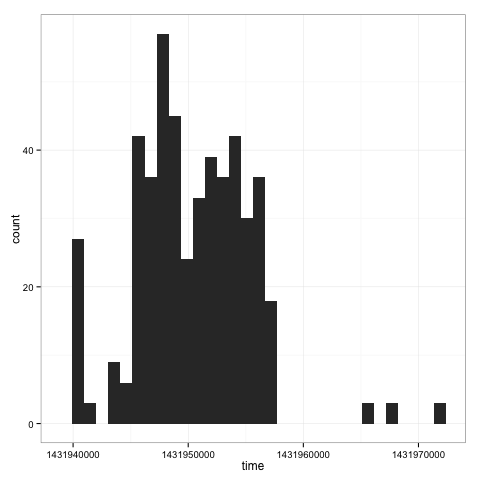

In [54]:
%%R
# When did people show up to do the experiment?
ggplot(Exp, aes(x = time)) + 
  geom_histogram() +
  theme_bw()

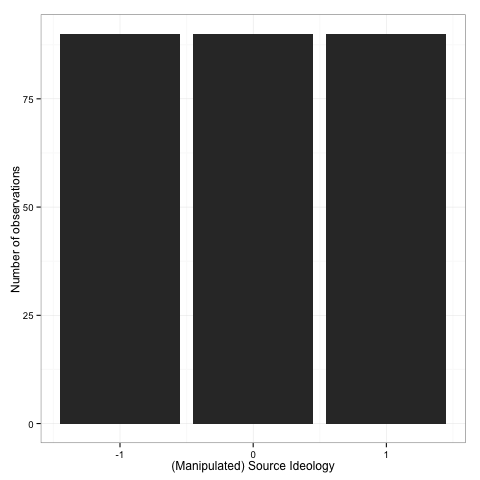

In [55]:
%%R
# Check that we have balanced exposures.
Results %>%
  group_by(source.ideology) %>%
  summarise(n = n(), num.users = length(unique(userid))) %>%
  ggplot(aes(x = source.ideology, y = n)) +
  geom_bar(stat = 'identity') +
  xlab('(Manipulated) Source Ideology') +
  ylab('Number of observations') +
  theme_bw()

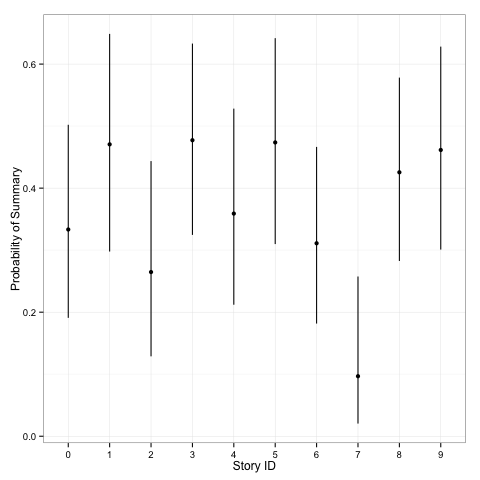

In [56]:
%%R
# Summary rate by story to see if any stories are weird.
Sum %>%
  group_by(story_key) %>%
  summarise(k = sum(summary), n = n(),
            p = mean(summary),
            lcl = binom.test(k, n)$conf.int[1], 
            ucl = binom.test(k, n)$conf.int[2]) %>%
  ggplot(aes(x = factor(story_key), y = p, ymin = lcl, ymax = ucl)) +
  geom_pointrange() +
  xlab('Story ID') +
  ylab('Probability of Summary') +
  theme_bw()

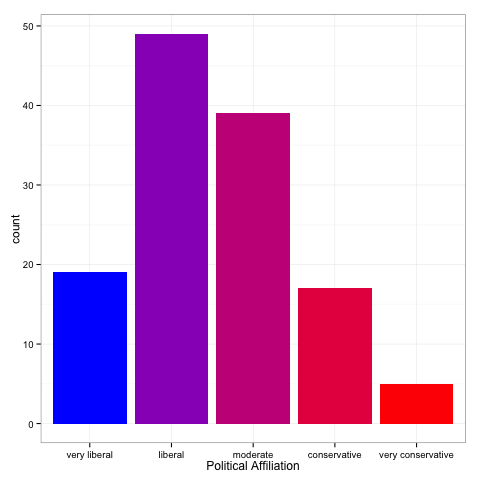

In [57]:
%%R

# Make sure our survey results look sane.
ideology.labels <- c('very liberal', 'liberal', 'moderate', 'conservative', 'very conservative')

Survey %>%
  ggplot(aes(x = factor(subject.ideology, labels = ideology.labels), fill = subject.ideology)) +
  geom_histogram() +
  scale_fill_gradient(low = "blue", high = "red") + # haha
  theme_bw() +
  theme(legend.position = 'none') +
  xlab('Political Affiliation')

# Measuring the ATE
Now we can tabulate the selections by source ideology to measure the ATE.

In [58]:
%%R
Results %>%
  group_by(opposed) %>%
  summarise(p.summary = mean(summary),
            measurement = 'p.summary') %>%
  mutate(opposed = factor(opposed, labels = c('not_opposed', 'opposed'))) %>%
  spread(opposed, p.summary) %>%
  mutate(ate = opposed - not_opposed)

Source: local data frame [1 x 4]

  measurement not_opposed   opposed        ate
1   p.summary   0.4166667 0.2888889 -0.1277778


#Modeling the Results
We usually prefer modeling the data using a regression.  We'll show how to use linear regression to perform correct inference on data with dependence, control variables, and larger than you can fit into memory.

##Outline

* i.i.d. case (with and without covariates)
* bootstrapping to deal with dependence
* using data reduction with weighted regressions

# I.i.d. case
If your data are i.i.d (which is pretty rare), then you can use an OLS regression and trust the standard errors on the treatment variable that `R` produces.

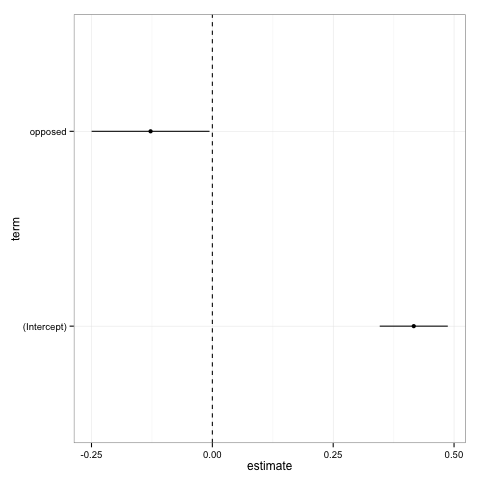

In [60]:
%%R
lm(summary ~ opposed, data = Results) %>%
  tidy %>%
  ggplot(aes(x = term, y = estimate, 
             ymin = estimate - 1.96*std.error, 
             ymax = estimate + 1.96*std.error)) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()

# I.i.d. case with control variables
Including control variables in your regression shouldn't change the ATE estimate, but it might help with precision (giving you smaller confidence intervals).

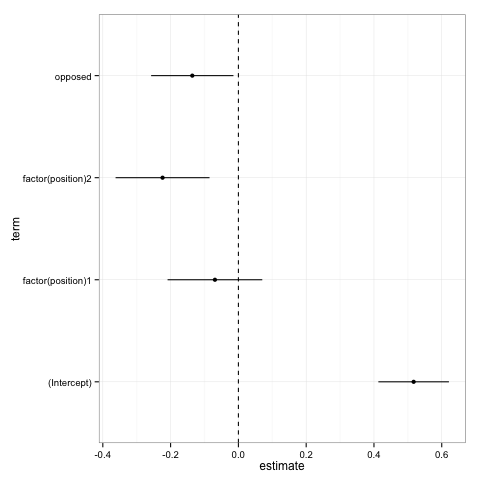

In [61]:
%%R
# In this case we think the position should help explain variation in the outcome (which is plausible).
lm(summary ~ opposed + factor(position), data = Results) %>%
  tidy %>%
  ggplot(aes(x = term, y = estimate, 
             ymin = estimate - 1.96*std.error, 
             ymax = estimate + 1.96*std.error)) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()

# Bootstrapping to get confidence intervals

If your data exhibits dependence, then you want to use a bootstrap to get correct inference.  In our experiment we resample both users and stories, so the true model has two way dependence.  We'll start with just user-level dependence:

In [62]:
%%R
suppressMessages({
    # install.packages(c('lmtest', 'Hmisc', 'foreach'))
    source('css_stats.R') # Provides `clustered.bootstrap`
})

In [64]:
%%R 

fitter <- function(.data) {
    lm(summary ~ opposed, data = .data, weights = .weights) %>%
    tidy
}

iid.replicates    <- iid.bootstrap(Results, fitter, .combine = bind_rows)
oneway.replicates <- clustered.bootstrap(Results, c('userid'), fitter, .combine = bind_rows)
twoway.replicates <- clustered.bootstrap(Results, c('userid', 'story_key'), fitter, .combine = bind_rows)

head(iid.replicates)

Source: local data frame [6 x 5]

         term    estimate  std.error  statistic      p.value
1 (Intercept)  0.38541667 0.04943752  7.7960356 1.317071e-12
2     opposed -0.05932971 0.08686042 -0.6830465 4.957062e-01
3 (Intercept)  0.46315789 0.05030158  9.2076207 5.353531e-16
4     opposed -0.16083231 0.09011290 -1.7847868 7.652517e-02
5 (Intercept)  0.40000000 0.05081666  7.8714335 8.416719e-13
6     opposed -0.09811321 0.08347112 -1.1754150 2.418097e-01


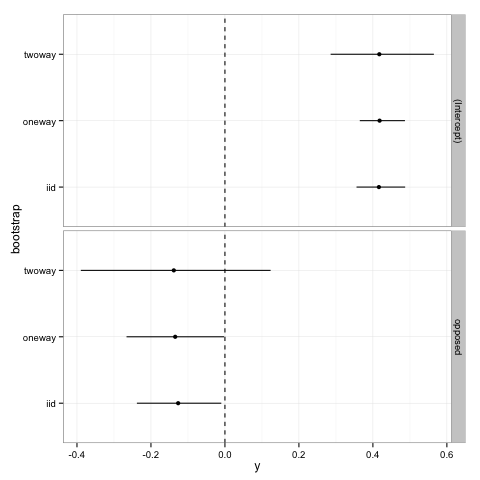

In [65]:
%%R
replicates <- bind_rows(
    iid.replicates %>% mutate(bootstrap = 'iid'),
    oneway.replicates %>% mutate(bootstrap = 'oneway'),
    twoway.replicates %>% mutate(bootstrap = 'twoway')
)

replicates %>%
  group_by(term, bootstrap) %>%
  summarise(y = mean(estimate), lcl = quantile(estimate, 0.025), ucl = quantile(estimate, 0.975)) %>%
  ggplot(aes(x = bootstrap, y = y, ymin = lcl, ymax = ucl)) +
  facet_grid(term ~ .) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()

#Using Data Reduction

If you have a lot of data, sometimes it's a lot easier to group it and fit weighted models.  We show how to do that here.

In [70]:
%%R

Results.small <- Results %>%
  group_by(summary, opposed) %>%
  summarise(cases = n())

Results.small

Source: local data frame [4 x 3]
Groups: summary

  summary opposed cases
1       0       0   105
2       0       1    64
3       1       0    75
4       1       1    26


# Fitting Reduced Data

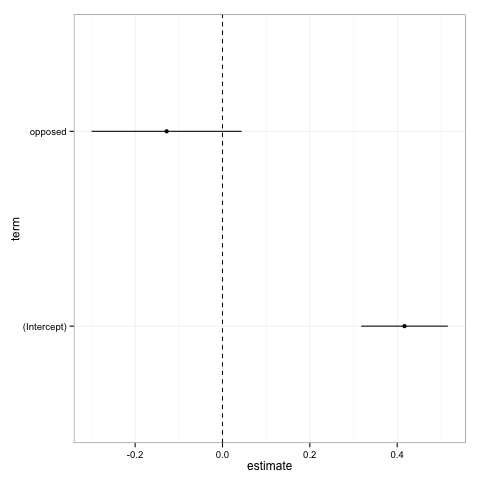

In [80]:
%%R

lm(summary ~ opposed, data = Results.small, weights = cases) %>%
  coeftest.freq %>%
  tidy %>%
  ggplot(aes(x = term, y = estimate, 
             ymin = estimate - 1.96*std.error, 
             ymax = estimate + 1.96*std.error)) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()  


# Reducing data when you have covariates

If your covariates are discrete and low-cardinality, you can still use data reduction.

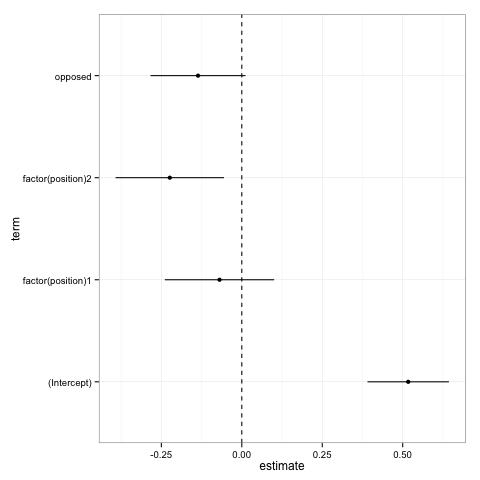

In [83]:
%%R 
Results.medium <- Results %>%
  group_by(summary, opposed, position) %>%
  summarise(cases = n())

lm(summary ~ opposed + factor(position), data = Results.medium, weights = cases) %>%
  coeftest.freq %>%
  tidy %>%
  ggplot(aes(x = term, y = estimate, 
             ymin = estimate - 1.96*std.error, 
             ymax = estimate + 1.96*std.error)) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()  

# Bootstrapping Reduced Data

If your data are dependent and large, you can combine data reduction with the bootstrap:

1. Generate a bootstrap replicate
2. Reduce that replicate
3. Fit a model on the reduced replicate

In [87]:
%%R

reduced.fitter <- function(.data) {
    reduced.data <- .data %>%
       group_by(summary, opposed, position) %>%
       summarise(cases = sum(.weights))
    lm(summary ~ opposed + factor(position), data = reduced.data, weights = cases) %>%
    tidy
}

twoway.replicates <- clustered.bootstrap(Results, c('userid', 'story_key'), reduced.fitter, .combine = bind_rows)

head(twoway.replicates)

Source: local data frame [6 x 5]

               term   estimate std.error  statistic    p.value
1       (Intercept)  0.6571214 0.3429817  1.9159079 0.10385371
2           opposed -0.2283353 0.3953662 -0.5775287 0.58458733
3 factor(position)1 -0.1519452 0.4424254 -0.3434370 0.74298410
4 factor(position)2 -0.5204542 0.4622664 -1.1258750 0.30322677
5       (Intercept)  0.5271112 0.2834196  1.8598258 0.09995736
6           opposed -0.2138669 0.3424873 -0.6244519 0.54972053


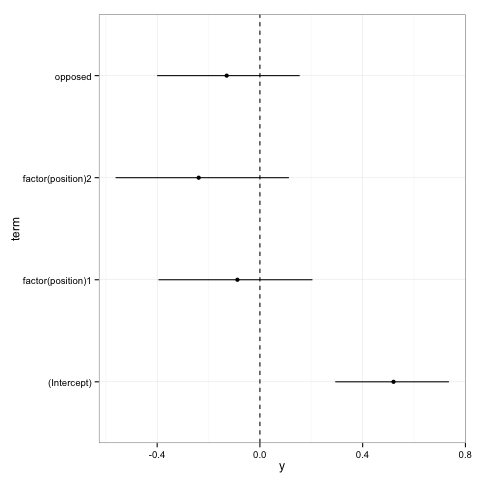

In [88]:
%%R

twoway.replicates %>%
  group_by(term) %>%
  summarise(y = mean(estimate), lcl = quantile(estimate, 0.025), ucl = quantile(estimate, 0.975)) %>%
  ggplot(aes(x = term, y = y, ymin = lcl, ymax = ucl)) +
  geom_pointrange() +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  coord_flip() +
  theme_bw()